In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support,confusion_matrix
import seaborn as sns

# ◆データ概要

In [2]:
kick = pd.read_csv("ks-projects-201801.csv")
kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [5]:
kick.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


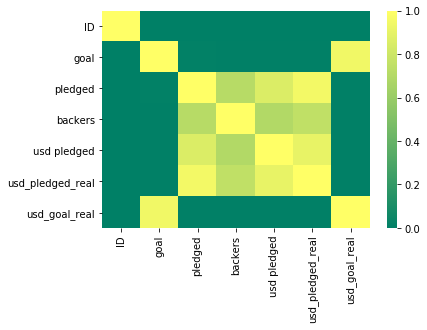

In [6]:
sns.heatmap(kick.corr(),cmap="summer")

In [7]:
display(kick["state"].value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

state
canceled       1875.463782
failed         1133.741030
live           1254.124725
successful    17356.034449
suspended      7838.542478
undefined              NaN
Name: usd pledged, dtype: float64


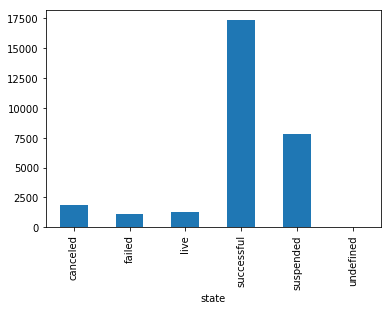

In [8]:
print(kick.groupby(["state"]).mean()["usd pledged"])
kick.groupby(["state"]).mean()["usd pledged"].plot.bar()


In [18]:
kick.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
state_n                0
dtype: int64

# ◆欠損値の補正  
  
  usd pledgedの欠損値をstate毎の平均値で埋めたかったけど、上手く実装できなかった。

In [9]:
#for df in kick:
#    for state in kick.state.unique():
#        df.loc["usd pledged"]
#        df.loc[(df["usd pledged"].isnull())&(df["state"]==state),"usd pledged"] = df.loc[df["state"]==state,'usd pledged'].mean()



3797

# ◆数値データへの変換  


In [10]:
#stateの<sucessful>を"1",それ以外を"0"に置換
#おそらく、改善余地としてsuspendedとか、cancelは区別した方が良いかもしれないけど、まずは単純にやってみる。
for df in [kick]:
    df['state_n'] = df['state'].values
    df['state_n'] = df["state_n"].replace(["successful"],1)
    df['state_n'] = df["state_n"].replace([["failed"],["canceled"],["undefined"],["live"],["suspended"]],0)


In [11]:
kick["main_category"].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [12]:
for df in [kick]:
    df['main_category'] = df["main_category"].replace(["Publishing"],1)
    df['main_category'] = df["main_category"].replace(["Film & Video"],2)
    df['main_category'] = df["main_category"].replace(["Music"],3)
    df['main_category'] = df["main_category"].replace(["Food"],4)
    df['main_category'] = df["main_category"].replace(["Design"],5)
    df['main_category'] = df["main_category"].replace(["Crafts"],6)
    df['main_category'] = df["main_category"].replace(["Games"],7)
    df['main_category'] = df["main_category"].replace(["Comics"],8)
    df['main_category'] = df["main_category"].replace(["Fashion"],9)
    df['main_category'] = df["main_category"].replace(["Theater"],10)
    df['main_category'] = df["main_category"].replace(["Art"],11)
    df['main_category'] = df["main_category"].replace(["Photography"],12)
    df['main_category'] = df["main_category"].replace(["Technology"],13)
    df['main_category'] = df["main_category"].replace(["Dance"],14)
    df['main_category'] = df["main_category"].replace(["Journalism"],15)



In [13]:
kick["currency"].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'NOK', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD', 'JPY'], dtype=object)

In [14]:
for df in [kick]:
    df['currency'] = df["currency"].replace(["GBP"],1)
    df['currency'] = df["currency"].replace(["USD"],2)
    df['currency'] = df["currency"].replace(["CAD"],3)
    df['currency'] = df["currency"].replace(["AUD"],4)
    df['currency'] = df["currency"].replace(["NOK"],5)
    df['currency'] = df["currency"].replace(["EUR"],6)
    df['currency'] = df["currency"].replace(["MXN"],7)
    df['currency'] = df["currency"].replace(["SEK"],8)
    df['currency'] = df["currency"].replace(["NZD"],9)
    df['currency'] = df["currency"].replace(["CHF"],10)
    df['currency'] = df["currency"].replace(["DKK"],11)
    df['currency'] = df["currency"].replace(["HKD"],12)
    df['currency'] = df["currency"].replace(["SGD"],13)
    df['currency'] = df["currency"].replace(["JPY"],14)


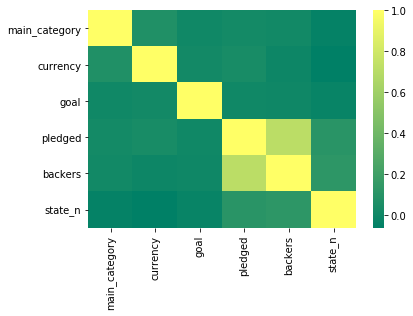

In [26]:
sns.heatmap(kick.corr(),cmap="summer")

# ◆数値データ化したので、再度データ概要分析   
  
  

Text(0.5, 1.0, 'The number of success/other Projects')

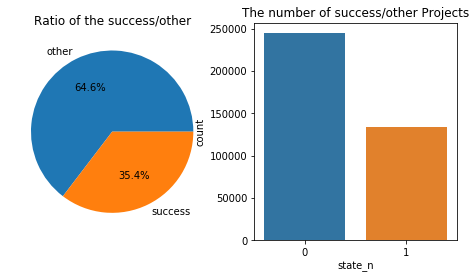

In [16]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].pie(kick["state_n"].value_counts(),labels=["other","success"] , autopct='%.1f%%' )

ax[0].set_title("Ratio of the success/other")
sns.countplot(kick["state_n"],ax=ax[1])
ax[1].set_title("The number of success/other Projects")

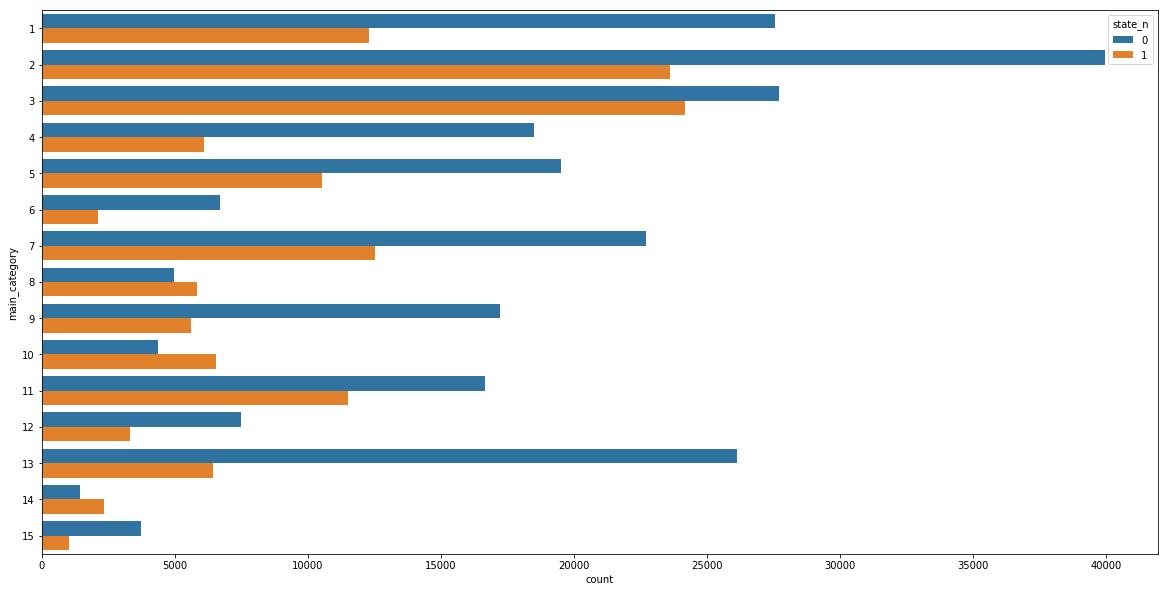

In [17]:

plt.figure(figsize=(20, 10))
sns.countplot(y="main_category",hue="state_n",data=kick)

# ◆不要データの削除
  
ID:　成功か否かに関係ない  
name: 成功か否かに関係ない(ひとまずは)  
deadline: 関係なさそう  
category: 値がバラバラすぎる。main_categoryを利用。  
usd pledged: 欠損値があるので。（本当は補正して使いたい）   
country: currencyとほぼ同じ意味  
usd_Pledged_real: 回帰分析用だと思うので消す  
usd_goal_real: 回帰分析用だと思うので消す  
launched: もしかしたら創立年によって成功率に影響あるかもしれないけど、今回は消す。


In [20]:
drop_columns = ['ID', 'name', 'deadline', 'usd pledged','country','usd_pledged_real','usd_goal_real','state','category','launched']
kick = kick.drop(drop_columns, axis = 1)


        main_category  currency      goal   pledged  backers  state_n
0                   1         1    1000.0      0.00        0        0
1                   2         2   30000.0   2421.00       15        0
2                   2         2   45000.0    220.00        3        0
3                   3         2    5000.0      1.00        1        0
4                   2         2   19500.0   1283.00       14        0
5                   4         2   50000.0  52375.00      224        1
6                   4         2    1000.0   1205.00       16        1
7                   4         2   25000.0    453.00       40        0
8                   5         2  125000.0   8233.00       58        0
9                   2         2   65000.0   6240.57       43        0
10                  1         3    2500.0      0.00        0        0
11                  3         2   12500.0  12700.00      100        1
12                  6         2    5000.0      0.00        0        0
13                  

# ◆ロジスティック回帰分析実施  

In [21]:
y = kick["state_n"].values
X = kick.drop('state_n', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}'.format(w0, w1, w2, w3, w4, w5))

w0 = 661.380, w1 = 4015.427, w2 = 1381.748, w3 = -20311.825, w4 = 19354.401, w5 = 5508.447


In [23]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -3.155
正答率 = 90.865%


In [24]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = Other', '正解 = Successful'], 
                        columns=['予測 = Other', '予測 = Successful'])
conf_mat

,予測 = Other,予測 = Successful
正解 = Other,242369,2336
正解 = Successful,32253,101703


In [25]:
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 88.255%
再現率（Recall） = 99.045%
F1値（F1-score） = 93.340%
